In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
import cactas as C

In [4]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2023-10-23 19:11:03.908543: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-10-23 19:11:06.878984: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 19:11:06.881487: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-10-23 19:11:07.243946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-10-23 19:11:07.246451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [5]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'

In [6]:
images, labels = C.Helper.load_data(DATAPATH)

In [7]:
X_train, y_train, X_test, y_test = C.Helper.split_patients(images, labels)

In [8]:
X_train, y_train, X_test, y_test = C.Helper.normalization(DATAPATH, X_train, y_train, X_test, y_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13543, 512, 512, 1) (13543, 512, 512, 1) (3223, 512, 512, 1) (3223, 512, 512, 1)


In [11]:
cropped_X_train = []
cropped_y_train = []
cropped_X_test = []
cropped_y_test = []

In [12]:
from skimage.filters import threshold_otsu
import os
import mahotas as mh
import json

In [13]:
for i in range(y_train.shape[0]):
    thresh = threshold_otsu(y_train[i])
    binary = y_train[i] > (0.5 * thresh)
    relabel, obj = mh.label(binary)
    
    #print(f"Number of objects in image {i}: {obj}")

    for j in range(1, relabel.max()+1):
        single_label = np.zeros((relabel.shape), relabel.dtype)
        single_label[relabel == j] = 1

        bbox = mh.bbox(single_label)
        #print(bbox)


        label_cropped = y_train[i][bbox[0]:bbox[1],bbox[2]:bbox[3]] 
        image_cropped = X_train[i][bbox[0]:bbox[1],bbox[2]:bbox[3]]
        
        #print(label_cropped.shape)

        cropped_y_train.append(label_cropped)
        cropped_X_train.append(image_cropped)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


In [14]:
len(cropped_X_train), len(cropped_y_train)

(888, 888)

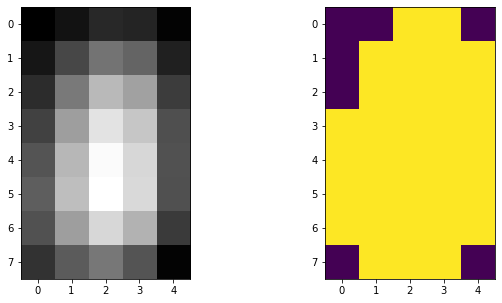

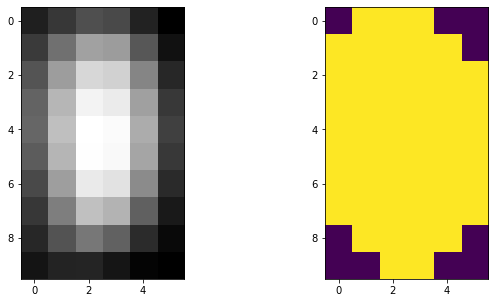

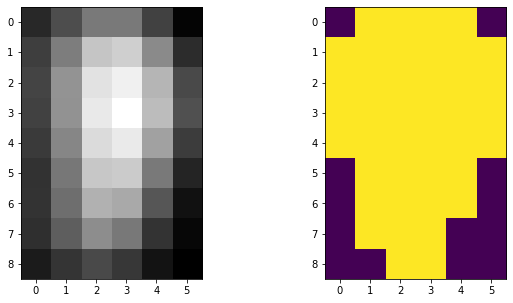

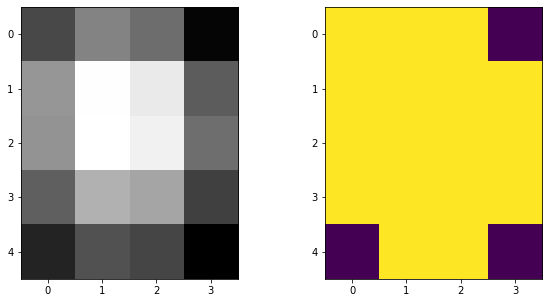

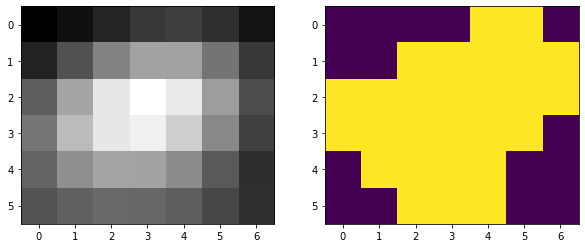

In [15]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(cropped_X_train[i], cmap='gray')
    ax2.imshow(cropped_y_train[i])
    plt.show()

In [16]:
for i in range(y_test.shape[0]):
    thresh = threshold_otsu(y_test[i])
    binary = y_test[i] > (0.5 * thresh)
    relabel, obj = mh.label(binary)
    
    #print(f"Number of objects in image {i}: {obj}")

    for j in range(1, relabel.max()+1):
        single_label = np.zeros((relabel.shape), relabel.dtype)
        single_label[relabel == j] = 1

        bbox = mh.bbox(single_label)
        #print(bbox)


        label_cropped = y_test[i][bbox[0]:bbox[1],bbox[2]:bbox[3]] 
        image_cropped = X_test[i][bbox[0]:bbox[1],bbox[2]:bbox[3]]
        
        #print(label_cropped.shape)

        cropped_y_test.append(label_cropped)
        cropped_X_test.append(image_cropped)

In [17]:
len(cropped_X_test), len(cropped_y_test)

(371, 371)

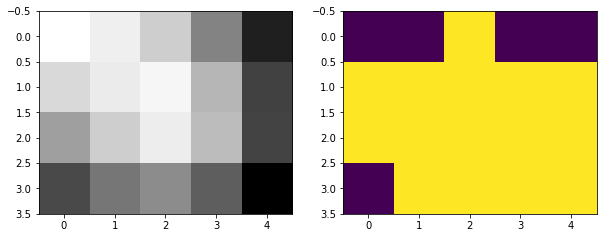

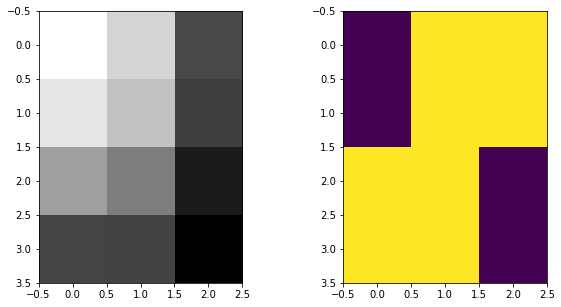

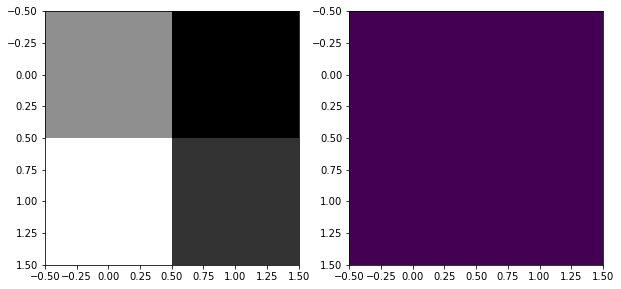

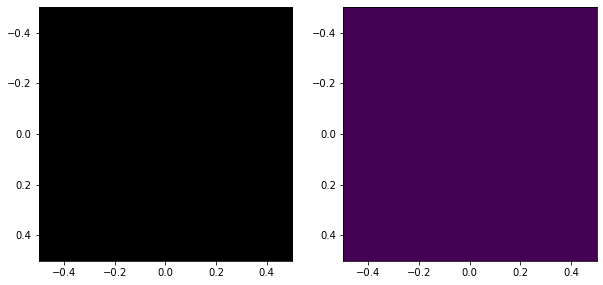

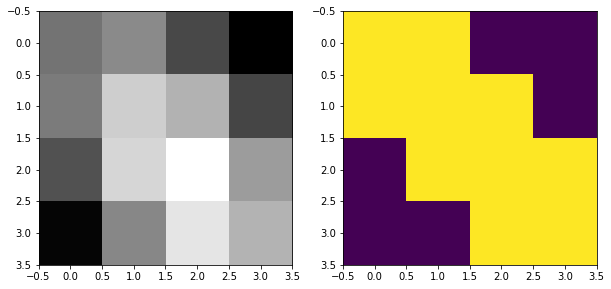

In [18]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(cropped_X_test[i], cmap='gray')
    ax2.imshow(cropped_y_test[i])
    plt.show()

In [19]:
force_square=True
center=True

In [20]:
maxX = 32
maxY = 32
slicecount = len(cropped_y_train)

for i in cropped_y_train:
    maxY = max(maxY, i.shape[0])
    maxX = max(maxX, i.shape[1])

if force_square:
    maxY = max(maxY, maxX)
    maxX = max(maxY, maxX)

startY = 0
startX = 0

padded_images = np.zeros((slicecount, maxY, maxX, 1), dtype=cropped_X_train[0].dtype)
padded_labels = np.zeros((slicecount, maxY, maxX, 1), dtype=cropped_y_train[0].dtype)

currentslice = 0
for i, img in enumerate(cropped_y_train):
    if center:
        startY = (maxY - img.shape[0]) // 2
        startX = (maxX - img.shape[1]) // 2
  
    padded_images[currentslice, startY:startY+img.shape[0], startX:startX+img.shape[1]] = cropped_X_train[i] 
    padded_labels[currentslice, startY:startY+img.shape[0], startX:startX+img.shape[1]] = cropped_y_train[i]

    currentslice += 1

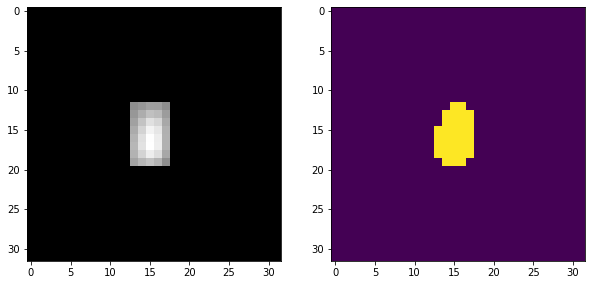

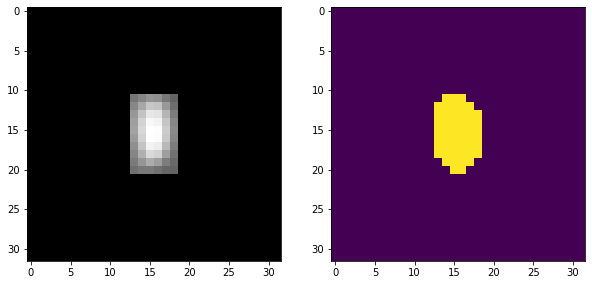

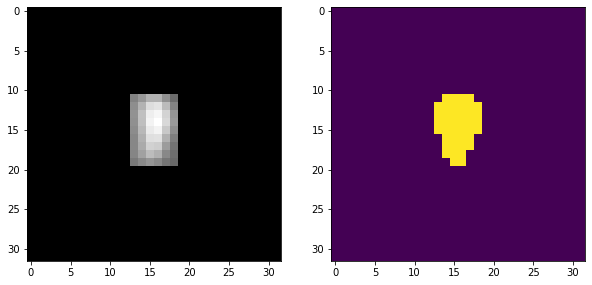

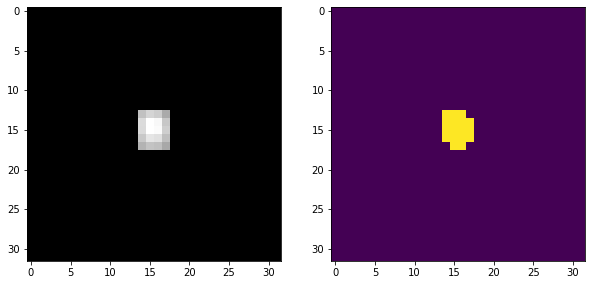

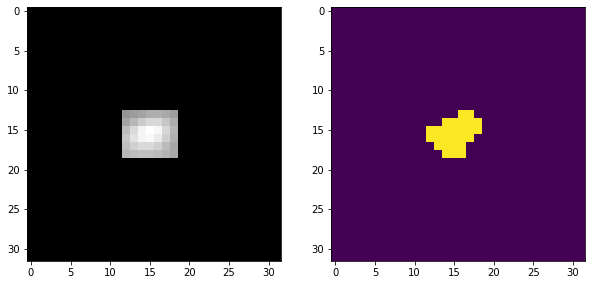

In [21]:
for i in range(5): # slicecount
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(padded_images[i], cmap='gray')
    ax2.imshow(padded_labels[i])
    plt.show()

In [22]:
maxX = 32
maxY = 32
slicecount = len(cropped_y_test)

for i in cropped_y_test:
    maxY = max(maxY, i.shape[0])
    maxX = max(maxX, i.shape[1])

if force_square:
    max_dim = max(maxY, maxX)
    maxY = max_dim
    maxX = max_dim

startY = 0
startX = 0

padded_images2 = np.zeros((slicecount, maxY, maxX, 1), dtype=cropped_X_test[0].dtype)
padded_labels2 = np.zeros((slicecount, maxY, maxX, 1), dtype=cropped_y_test[0].dtype)

currentslice = 0
for i, img in enumerate(cropped_y_test):
    if center:
        startY = (maxY - img.shape[0]) // 2
        startX = (maxX - img.shape[1]) // 2
  
    padded_images2[currentslice, startY:startY+img.shape[0], startX:startX+img.shape[1]] = cropped_X_test[i] 
    padded_labels2[currentslice, startY:startY+img.shape[0], startX:startX+img.shape[1]] = cropped_y_test[i]

    currentslice += 1

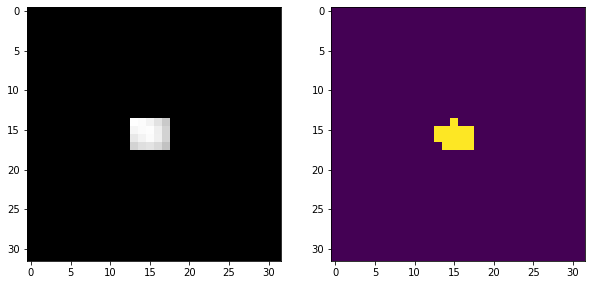

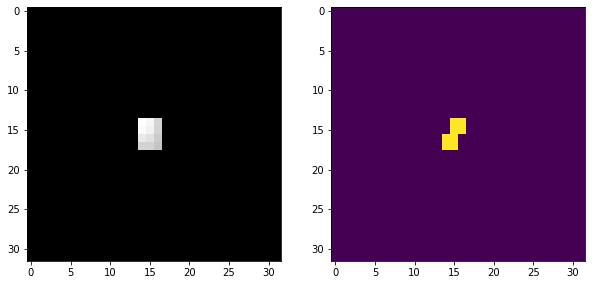

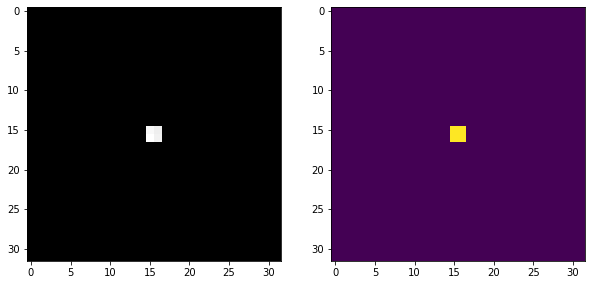

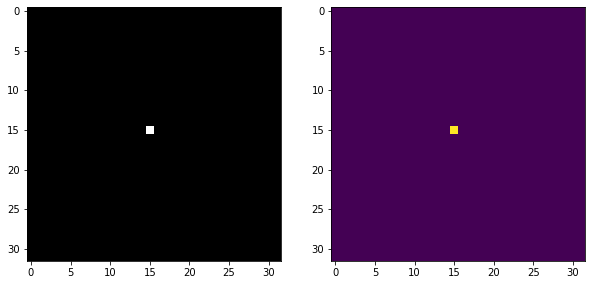

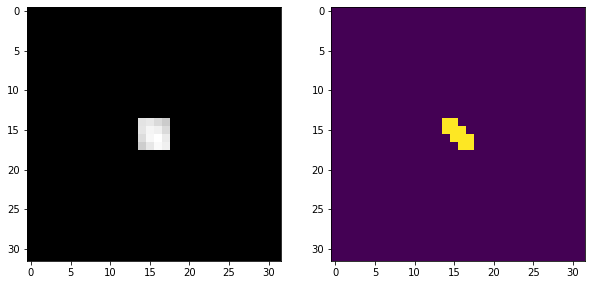

In [23]:
for i in range(5): # slicecount
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(padded_images2[i], cmap='gray')
    ax2.imshow(padded_labels2[i])
    plt.show()

In [24]:
padded_images[0].shape, padded_images2[0].shape

((32, 32, 1), (32, 32, 1))

In [25]:
padded_images.shape, padded_images2.shape

((888, 32, 32, 1), (371, 32, 32, 1))

In [26]:
padded_labels.shape, padded_labels2.shape

((888, 32, 32, 1), (371, 32, 32, 1))

In [27]:
round(padded_images.shape[0]*0.8)

710

In [28]:
num = round(padded_images.shape[0]*0.8)

In [29]:
from keras_unet.utils import get_patches

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [30]:
X_train_set = padded_images[:num]
y_train_set = padded_labels[:num]
X_val = padded_images[num:]
y_val = padded_labels[num:]

In [31]:
train_gen = C.Helper.augment(X_train_set, y_train_set)

In [32]:
X_train_set.shape, y_train_set.shape

((710, 32, 32, 1), (710, 32, 32, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

2023-10-23 19:14:29.815330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-10-23 19:14:29.817863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:bd:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-10-23 19:14:29.829707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2023-10-23 19:14:29.839711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-10-23 19:14:29.842284: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(train_gen, X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2023-10-23 19:14:30.910916: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-10-23 19:14:30.913307: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245800000 Hz


Epoch 1/200


2023-10-23 19:14:32.101933: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-10-23 19:14:33.023939: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-10-23 19:14:34.090438: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-10-23 19:14:34.090462: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-10-23 19:14:34.090830: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-23 19:14:35.455973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-10-23 19:14:36.500285: I tensorflow/stream_exec

23/23 [==============================] - 163s 4s/step - loss: 0.3304 - iou: 0.1193 - iou_thresholded: 0.1984 - val_loss: 0.0594 - val_iou: 0.3926 - val_iou_thresholded: 0.4208
Epoch 2/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0304 - iou: 0.4210 - iou_thresholded: 0.5372 - val_loss: 0.0235 - val_iou: 0.5149 - val_iou_thresholded: 0.6340
Epoch 3/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0212 - iou: 0.5204 - iou_thresholded: 0.6524 - val_loss: 0.0206 - val_iou: 0.5447 - val_iou_thresholded: 0.6945
Epoch 4/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0197 - iou: 0.5489 - iou_thresholded: 0.6637 - val_loss: 0.0214 - val_iou: 0.5692 - val_iou_thresholded: 0.6818
Epoch 5/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0180 - iou: 0.5761 - iou_thresholded: 0.6844 - val_loss: 0.0185 - val_iou: 0.5920 - val_iou_thresholded: 0.7226
Epoch 6/200
23/23 [==============================] - 0s 15ms/step - loss

23/23 [==============================] - 0s 15ms/step - loss: 0.0091 - iou: 0.7642 - iou_thresholded: 0.8330 - val_loss: 0.0109 - val_iou: 0.7703 - val_iou_thresholded: 0.8236
Epoch 45/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0088 - iou: 0.7755 - iou_thresholded: 0.8361 - val_loss: 0.0111 - val_iou: 0.7735 - val_iou_thresholded: 0.8215
Epoch 46/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0087 - iou: 0.7771 - iou_thresholded: 0.8413 - val_loss: 0.0110 - val_iou: 0.7675 - val_iou_thresholded: 0.8210
Epoch 47/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0087 - iou: 0.7697 - iou_thresholded: 0.8309 - val_loss: 0.0117 - val_iou: 0.7421 - val_iou_thresholded: 0.7989
Epoch 48/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0087 - iou: 0.7742 - iou_thresholded: 0.8381 - val_loss: 0.0112 - val_iou: 0.7700 - val_iou_thresholded: 0.8180
Epoch 49/200
23/23 [==============================] - 0s 16ms/step -

23/23 [==============================] - 0s 15ms/step - loss: 0.0044 - iou: 0.8780 - iou_thresholded: 0.9143 - val_loss: 0.0173 - val_iou: 0.7844 - val_iou_thresholded: 0.8078
Epoch 88/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0043 - iou: 0.8808 - iou_thresholded: 0.9185 - val_loss: 0.0174 - val_iou: 0.7874 - val_iou_thresholded: 0.8113
Epoch 89/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0040 - iou: 0.8883 - iou_thresholded: 0.9247 - val_loss: 0.0184 - val_iou: 0.7907 - val_iou_thresholded: 0.8107
Epoch 90/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0045 - iou: 0.8827 - iou_thresholded: 0.9183 - val_loss: 0.0167 - val_iou: 0.7914 - val_iou_thresholded: 0.8142
Epoch 91/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0042 - iou: 0.8828 - iou_thresholded: 0.9194 - val_loss: 0.0182 - val_iou: 0.7801 - val_iou_thresholded: 0.8036
Epoch 92/200
23/23 [==============================] - 0s 15ms/step -

23/23 [==============================] - 0s 15ms/step - loss: 0.0022 - iou: 0.9403 - iou_thresholded: 0.9578 - val_loss: 0.0312 - val_iou: 0.7808 - val_iou_thresholded: 0.7951
Epoch 131/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0020 - iou: 0.9434 - iou_thresholded: 0.9620 - val_loss: 0.0337 - val_iou: 0.7848 - val_iou_thresholded: 0.7990
Epoch 132/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0022 - iou: 0.9408 - iou_thresholded: 0.9594 - val_loss: 0.0299 - val_iou: 0.7900 - val_iou_thresholded: 0.8013
Epoch 133/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0023 - iou: 0.9370 - iou_thresholded: 0.9583 - val_loss: 0.0293 - val_iou: 0.7786 - val_iou_thresholded: 0.7900
Epoch 134/200
23/23 [==============================] - 0s 16ms/step - loss: 0.0020 - iou: 0.9436 - iou_thresholded: 0.9613 - val_loss: 0.0306 - val_iou: 0.7828 - val_iou_thresholded: 0.7930
Epoch 135/200
23/23 [==============================] - 0s 16ms/s

23/23 [==============================] - 0s 15ms/step - loss: 0.0014 - iou: 0.9595 - iou_thresholded: 0.9730 - val_loss: 0.0350 - val_iou: 0.7936 - val_iou_thresholded: 0.8010
Epoch 174/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0013 - iou: 0.9545 - iou_thresholded: 0.9684 - val_loss: 0.0359 - val_iou: 0.7933 - val_iou_thresholded: 0.8017
Epoch 175/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0014 - iou: 0.9598 - iou_thresholded: 0.9730 - val_loss: 0.0352 - val_iou: 0.8026 - val_iou_thresholded: 0.8099
Epoch 176/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0013 - iou: 0.9629 - iou_thresholded: 0.9745 - val_loss: 0.0373 - val_iou: 0.7951 - val_iou_thresholded: 0.8014
Epoch 177/200
23/23 [==============================] - 0s 15ms/step - loss: 0.0013 - iou: 0.9603 - iou_thresholded: 0.9729 - val_loss: 0.0357 - val_iou: 0.7921 - val_iou_thresholded: 0.8012
Epoch 178/200
23/23 [==============================] - 0s 15ms/s

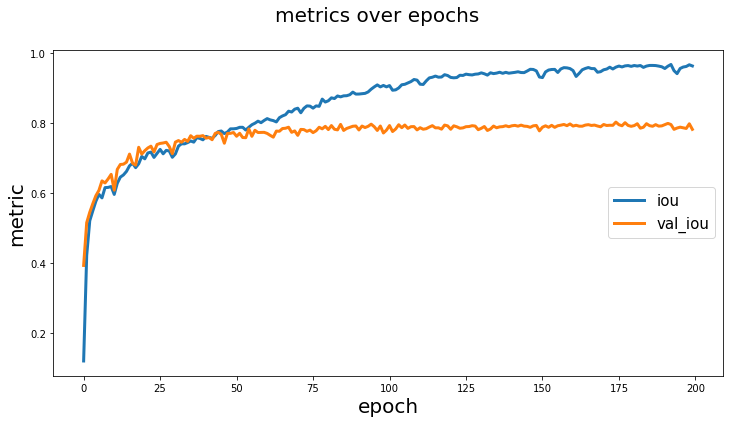

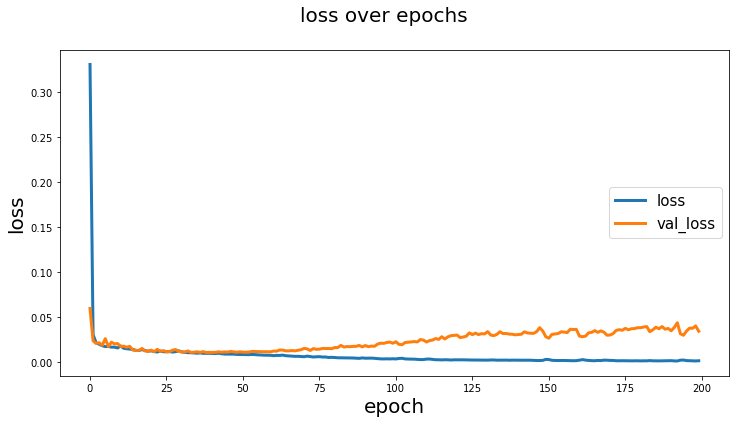

In [35]:
C.Helper.visualize_graph(history)

In [36]:

# Define patch size and overlap
patch_size = (32, 32)
overlap = 16

# Split the large image into patches with overlap
image_height, image_width = X_test[0].shape[0], X_test[0].shape[1]
patches = []
for i in range(len(X_test)):
    for y in range(0, image_height, patch_size[0]):
        for x in range(0, image_width, patch_size[1]):
            patch = X_test[i][y:y+patch_size[0], x:x+patch_size[1]]
            patches.append(patch)

patches = np.array(patches)            

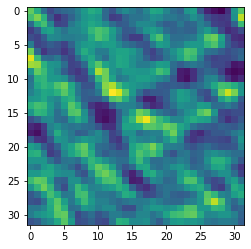

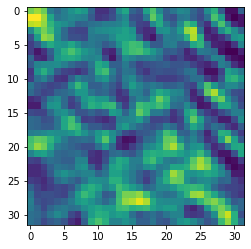

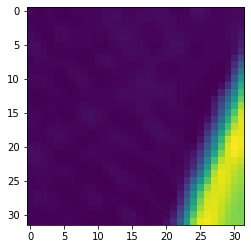

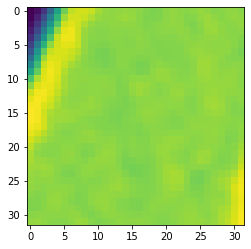

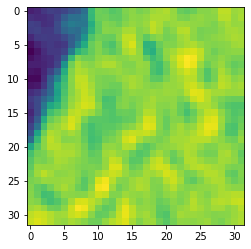

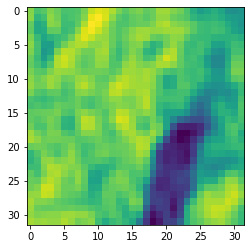

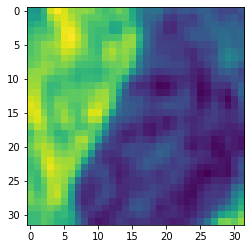

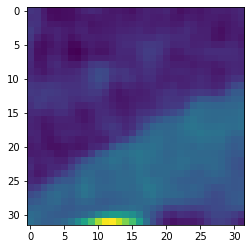

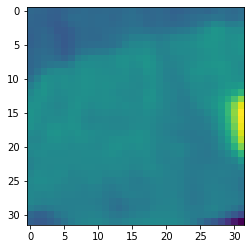

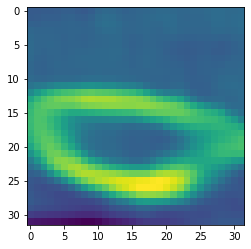

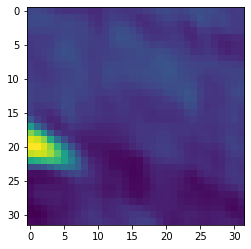

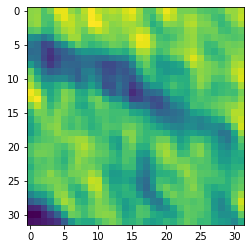

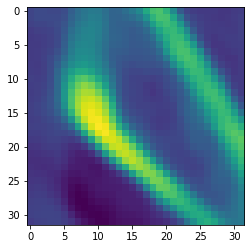

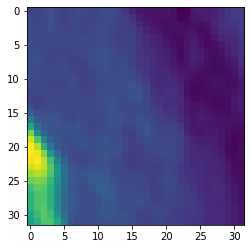

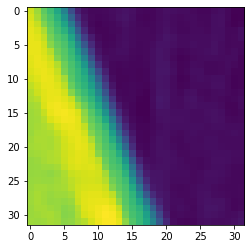

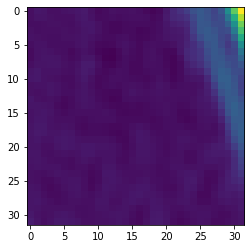

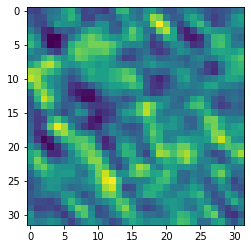

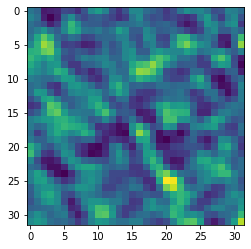

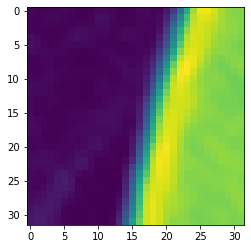

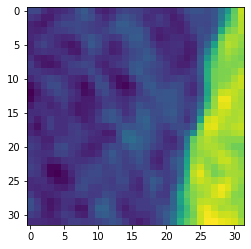

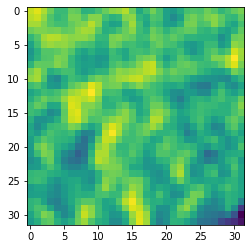

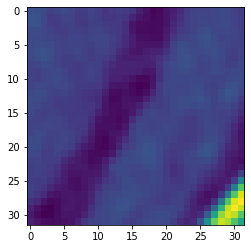

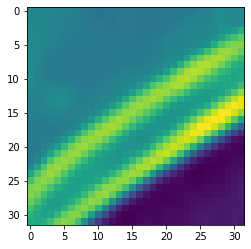

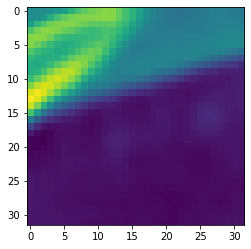

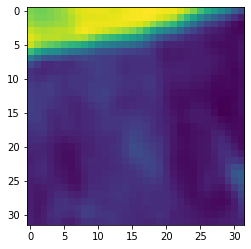

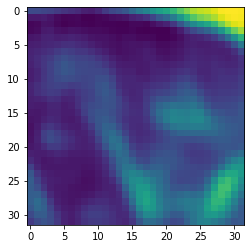

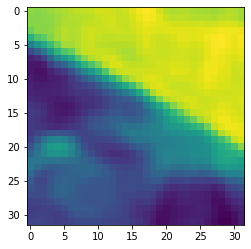

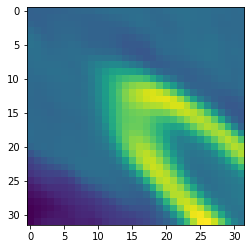

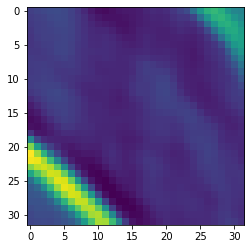

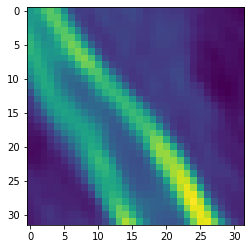

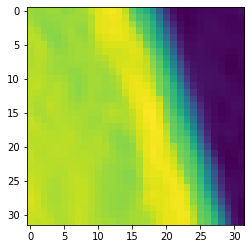

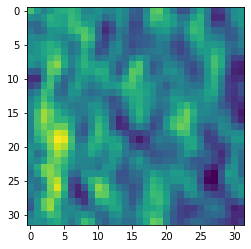

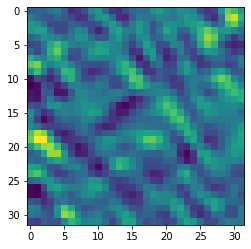

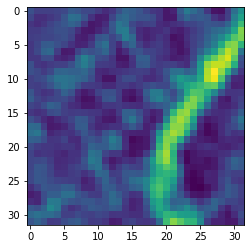

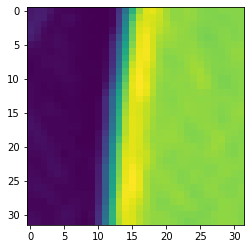

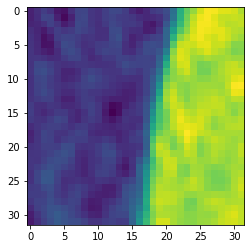

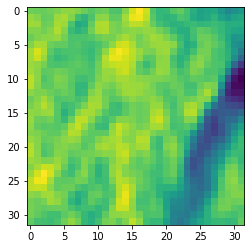

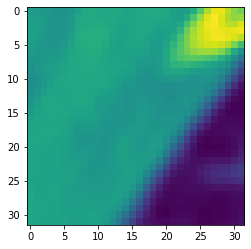

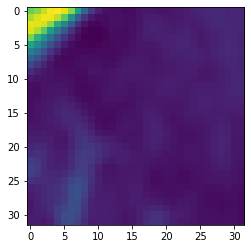

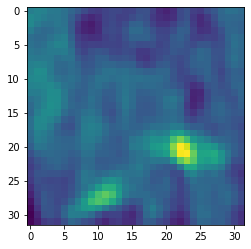

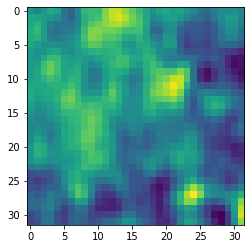

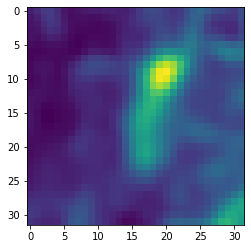

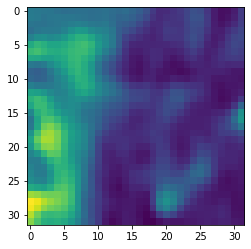

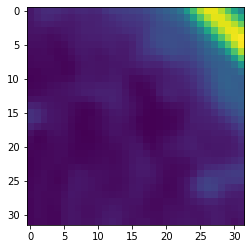

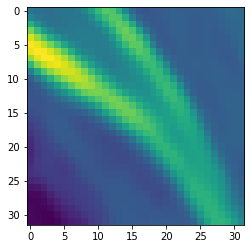

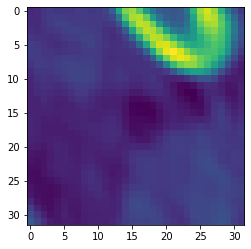

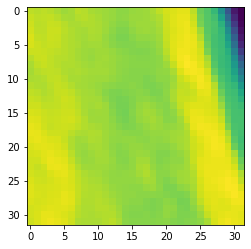

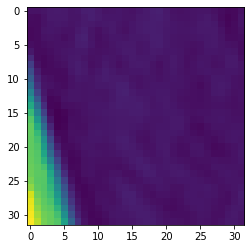

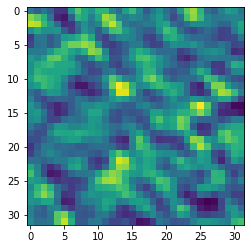

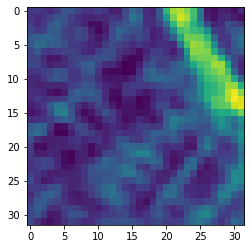

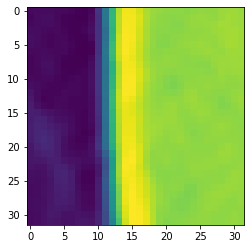

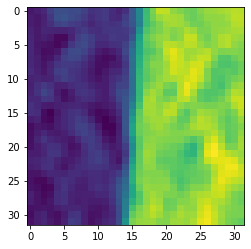

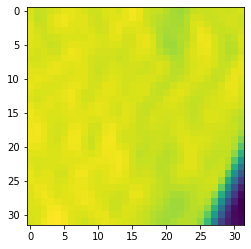

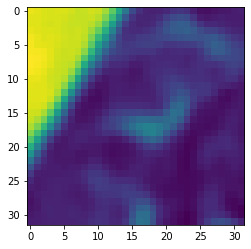

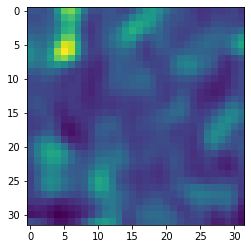

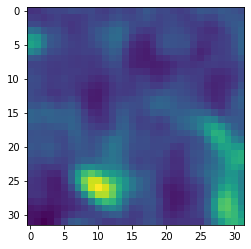

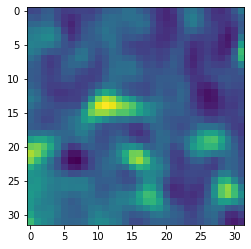

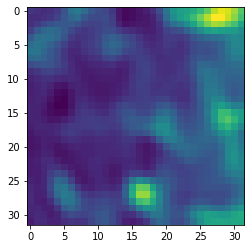

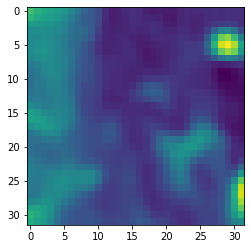

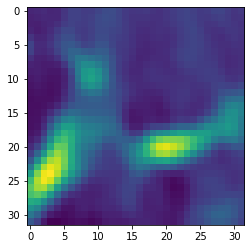

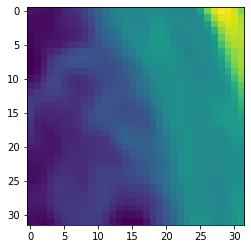

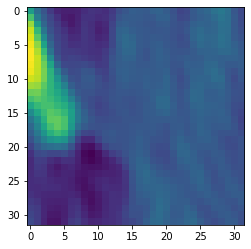

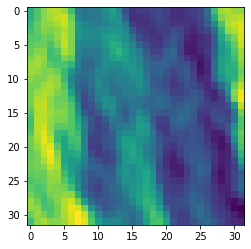

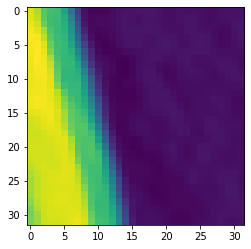

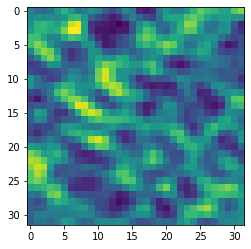

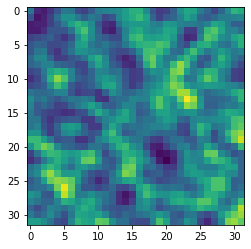

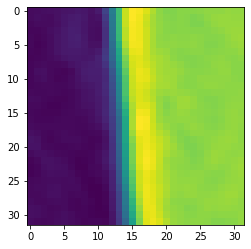

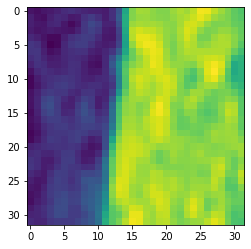

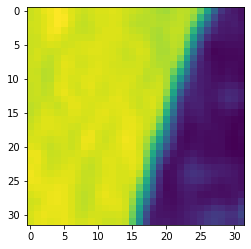

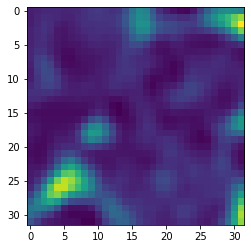

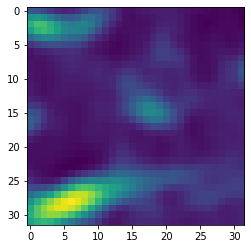

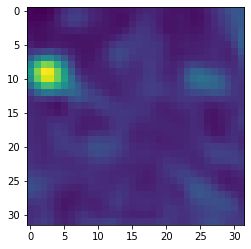

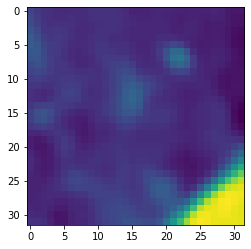

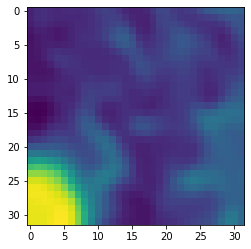

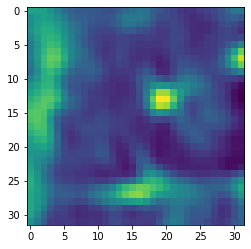

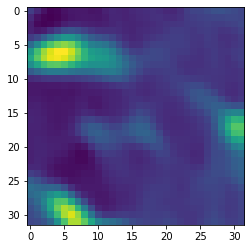

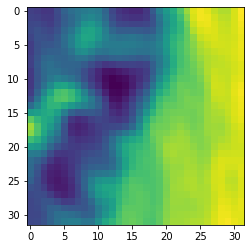

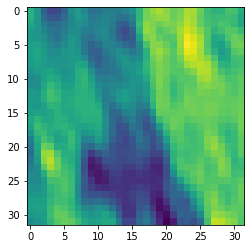

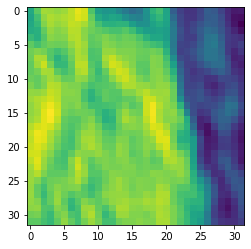

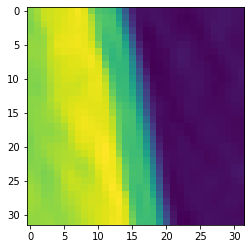

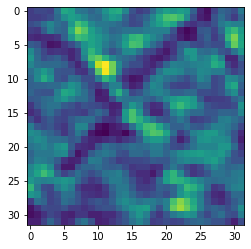

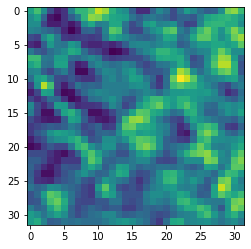

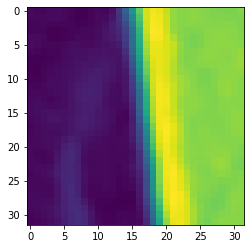

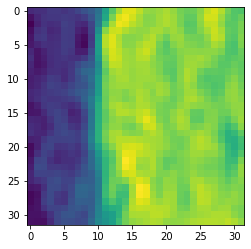

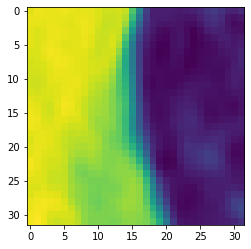

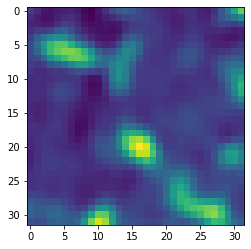

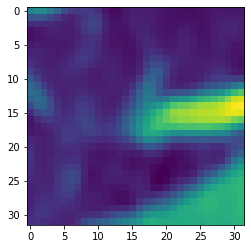

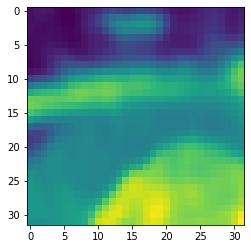

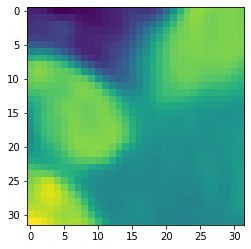

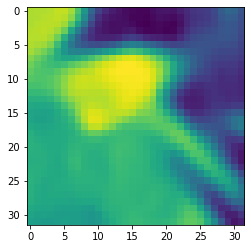

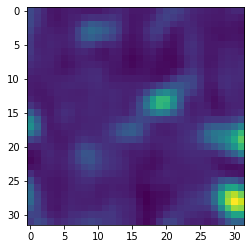

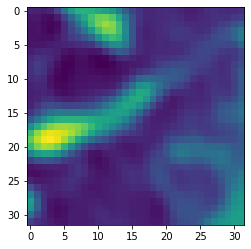

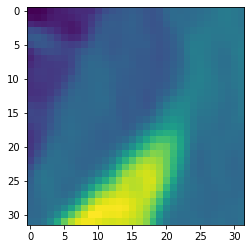

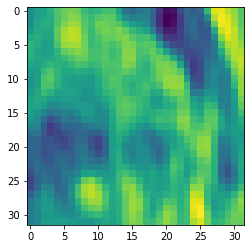

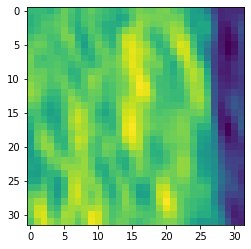

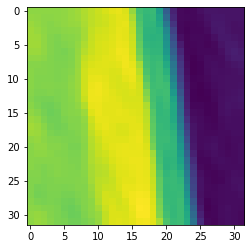

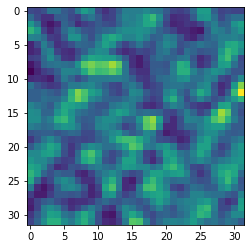

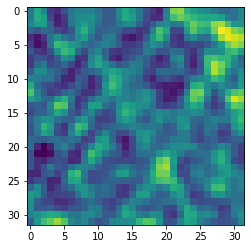

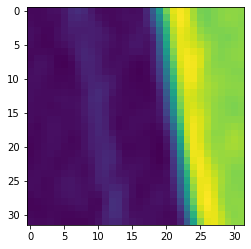

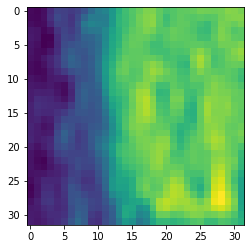

In [37]:
for i in range(5): # slicecount
    plt.imshow(patches[i])
    plt.show()

In [38]:
patches[0].shape, len(patches)

((32, 32, 1), 825088)

In [39]:
y_pred = C.Helper.prediction(patches, model)

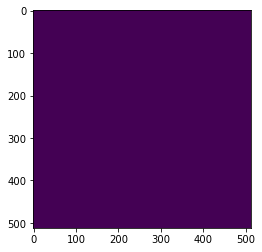

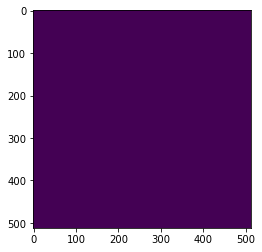

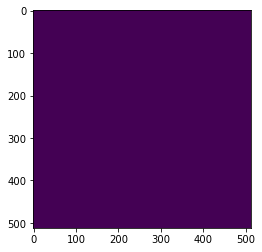

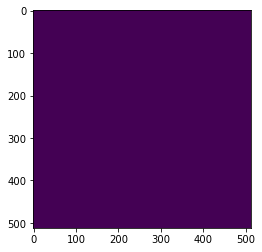

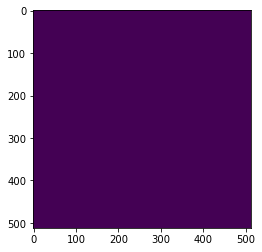

In [47]:
for i in range(5): # slicecount
    plt.imshow(y_test[i])
    plt.show()

In [48]:
# Split the large image into patches with overlap
label_height, label_width = y_test[0].shape[0], y_test[0].shape[1]
patches2 = []
for i in range(len(y_test)):
    for y in range(0, label_height, patch_size[0]):
        for x in range(0, label_width, patch_size[1]):
            patch = y_test[i][y:y+patch_size[0], x:x+patch_size[1]]
            patches2.append(patch)

patches2 = np.array(patches2)

In [49]:
patches2[0].shape, len(patches2)

((32, 32, 1), 825088)

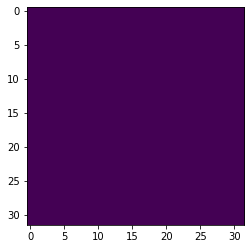

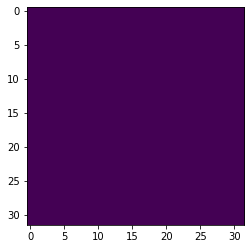

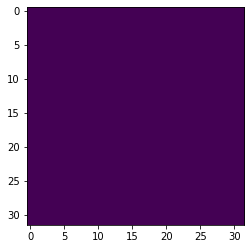

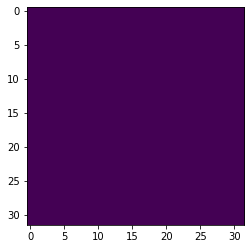

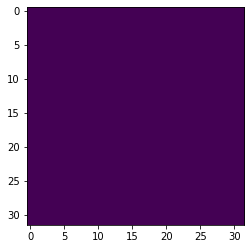

In [50]:
for i in range(300): # slicecount
    plt.imshow(patches2[i])
    plt.show()

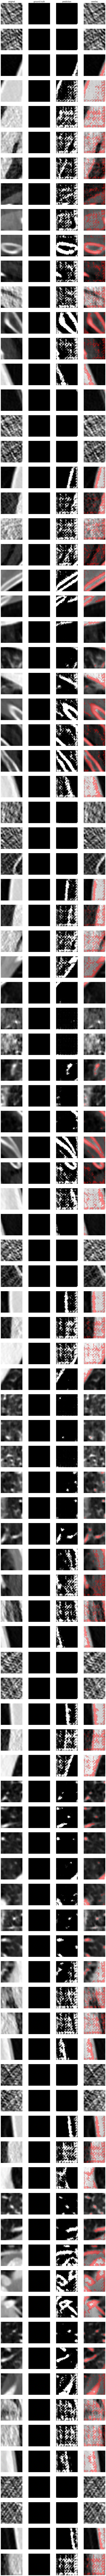

In [51]:
C.Helper.visualize_result(patches, patches2, y_pred)

In [52]:
C.Helper.evaluate(patches, patches2, model)

25784/25784 [==============================] - 116s 4ms/step - loss: 0.8264 - iou: 0.0368 - iou_thresholded: 0.0720
